# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [98]:
import pickle
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

random.seed(42)
random_state = 42
%matplotlib inline

In [2]:
# Load pickled data

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
print('Counts of each class in training set: \n',np.unique(y_train, return_counts=True)[1])
print('Counts of each class in testing set: \n',np.unique(y_test, return_counts=True)[1])

Counts of each class in training set: 
 [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]
Counts of each class in testing set: 
 [ 60 720 750 450 660 630 150 450 450 480 660 420 690 720 270 210 150 360
 390  60  90  90 120 150  90 480 180  60 150  90 150 270  60 210 120 390
 120  60 690  90  90  60  90]


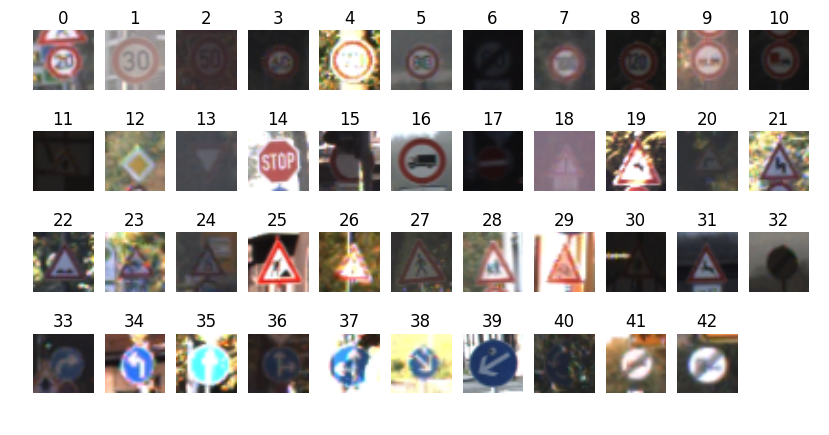

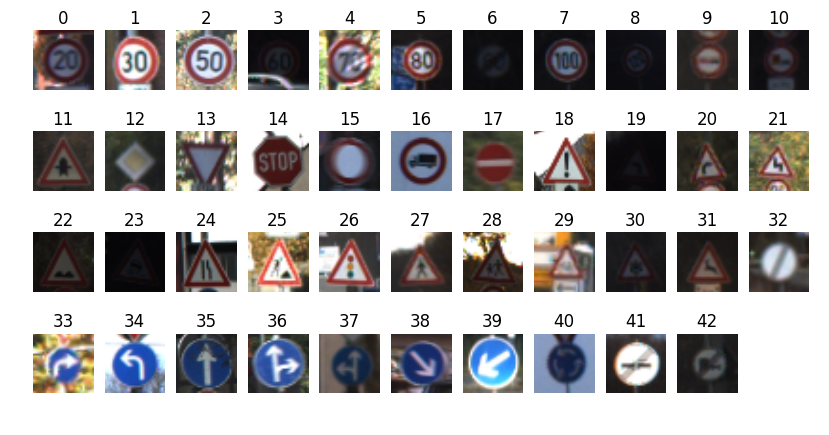

In [27]:
def getSampleImage(images, labels):
    '''Get a sample image from each class'''
    n_classes = np.unique(y_train).shape[0]
    samples = []
    for i in range(n_classes):
        y = np.where(labels==i)[0][0]
        samples.append(images[y])
    return samples

def plotImages(fig, images):
    '''Plot a RGB image from each class'''
    num_rows = 4
    num_cols = 11
    fig = plt.figure(fig,figsize=(10,5), dpi=32)
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)
    ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]
    for i, im in enumerate(images):
        ax[i].imshow(im)
        ax[i].set_title(i, loc='center')
        ax[i].axis('off')
    ax[i+1].axis('off')  
    
plotImages(1, getSampleImage(X_train, y_train))
plotImages(2, getSampleImage(X_test, y_test))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [71]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def cvtGrayNorm(images):
    '''Convert RGB images to grayscale, and normalize images from 0 to 1'''
    convImages = np.ndarray(shape=(images.shape[0],images.shape[1],images.shape[2],1), dtype=float)
    for i in range(images.shape[0]):
        img = images[i]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
        img2 = np.copy(img)
        img2 = cv2.normalize(img, img2, 0., 1, cv2.NORM_MINMAX)
        convImages[i, :, :, 0] = img2
    return convImages

X_train_cvt = cvtGrayNorm(X_train)
X_test_cvt = cvtGrayNorm(X_test)


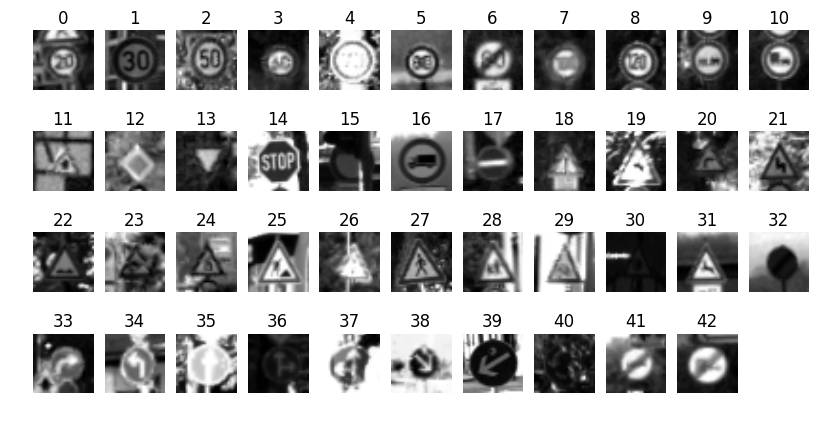

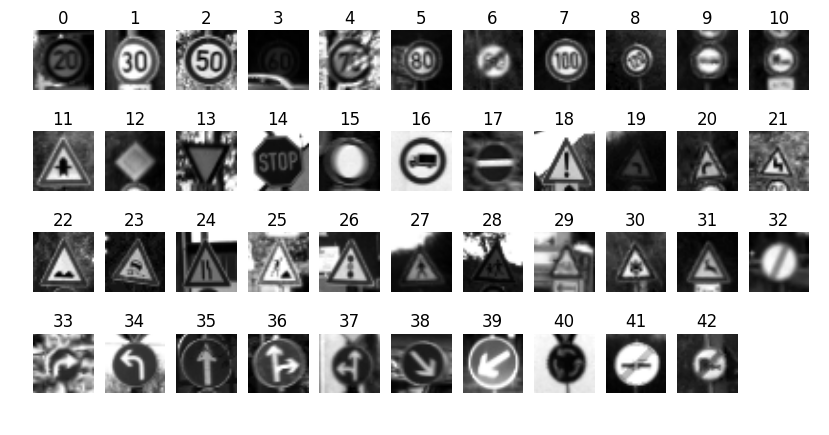

In [76]:
def plotImages2(fig, images):
    '''Plot a grayscale image from each class'''
    num_rows = 4
    num_cols = 11
    fig = plt.figure(fig,figsize=(10,5), dpi=32)
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)
    ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]
    for i, im in enumerate(images):
        ax[i].imshow(im[:, :, 0], cmap="gray")
        ax[i].set_title(i, loc='center')
        ax[i].axis('off')
    ax[i+1].axis('off') 

plotImages2(1, getSampleImage(X_train_cvt, y_train))
plotImages2(2, getSampleImage(X_test_cvt, y_test))

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

OpenCV library has been used to converted all images from colorspace RGB to grayscale, and then applied a normalization to all images in both training set and testing set to a range from 0 to 1.

In [77]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def random_transform(img):
    '''Randomly transform image with:
       translation: -2 to 2 pixels
       scale: 0.9 to 1.1
       rotation: -15 to 15 degrees'''
    transx = random.uniform(-2, 2)
    transy = random.uniform(-2, 2)
    scale = random.uniform(.9, 1.1)
    rotate = random.uniform(-15, 15)

    rows,cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2+transx,rows/2+transy), rotate, scale)
    dst = cv2.warpAffine(img, M, (cols, rows))
    return dst


In [79]:
labels, counts = np.unique(y_train, return_counts=True)
for i in labels:
    print("Class ", i, " has ", counts[i], "images.")

Class  0  has  210 images.
Class  1  has  2220 images.
Class  2  has  2250 images.
Class  3  has  1410 images.
Class  4  has  1980 images.
Class  5  has  1860 images.
Class  6  has  420 images.
Class  7  has  1440 images.
Class  8  has  1410 images.
Class  9  has  1470 images.
Class  10  has  2010 images.
Class  11  has  1320 images.
Class  12  has  2100 images.
Class  13  has  2160 images.
Class  14  has  780 images.
Class  15  has  630 images.
Class  16  has  420 images.
Class  17  has  1110 images.
Class  18  has  1200 images.
Class  19  has  210 images.
Class  20  has  360 images.
Class  21  has  330 images.
Class  22  has  390 images.
Class  23  has  510 images.
Class  24  has  270 images.
Class  25  has  1500 images.
Class  26  has  600 images.
Class  27  has  240 images.
Class  28  has  540 images.
Class  29  has  270 images.
Class  30  has  450 images.
Class  31  has  780 images.
Class  32  has  240 images.
Class  33  has  689 images.
Class  34  has  420 images.
Class  35  has 

In [80]:
# Add addtional jittered images into each class of  
# the training set to 3000 images for balanced classes.

def addJitteredImages(X, y, num):
    labels, counts = np.unique(y, return_counts=True)
    total_num = num * len(counts) - np.sum(counts)
    X_add = np.empty([total_num,X.shape[1],X.shape[2],X.shape[3]], dtype=float)
    y_add = np.empty([total_num,], dtype=np.uint8)
    total_idx = 0
    base_idx = 0
    for i in labels:
        for j in range(num-counts[i]):
            index = j % counts[i] + base_idx
            image = random_transform(X[index,:,:,0])
            X_add[total_idx,:,:,0] = image
            y_add[total_idx] = y[index]
            total_idx += 1
        base_idx += counts[i]
    X_all = np.concatenate((X, X_add), axis=0)
    y_all = np.concatenate((y, y_add), axis=0)
    return X_all, y_all

In [81]:
X_train_all, y_train_all = addJitteredImages(X_train_cvt, y_train, 3000)


In [86]:
# Split validation data set from training data set
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train_all, y_train_all, test_size=60*n_classes, random_state=random_state, stratify=y_train_all)

# Transform labels into one-hot encoding
encoder = LabelBinarizer()
encoder.fit(y_train_final)
y_train_1hot = encoder.transform(y_train_final)
y_valid_1hot = encoder.transform(y_valid)
y_test_1hot = encoder.transform(y_test)


counts_valid = np.sum(y_valid_1hot, axis=0)
for i in labels:
    print("Class ", i, " has ", counts_valid[i], "images.")
    

Class  0  has  60 images.
Class  1  has  60 images.
Class  2  has  60 images.
Class  3  has  60 images.
Class  4  has  60 images.
Class  5  has  60 images.
Class  6  has  60 images.
Class  7  has  60 images.
Class  8  has  60 images.
Class  9  has  60 images.
Class  10  has  60 images.
Class  11  has  60 images.
Class  12  has  60 images.
Class  13  has  60 images.
Class  14  has  60 images.
Class  15  has  60 images.
Class  16  has  60 images.
Class  17  has  60 images.
Class  18  has  60 images.
Class  19  has  60 images.
Class  20  has  60 images.
Class  21  has  60 images.
Class  22  has  60 images.
Class  23  has  60 images.
Class  24  has  60 images.
Class  25  has  60 images.
Class  26  has  60 images.
Class  27  has  60 images.
Class  28  has  60 images.
Class  29  has  60 images.
Class  30  has  60 images.
Class  31  has  60 images.
Class  32  has  60 images.
Class  33  has  60 images.
Class  34  has  60 images.
Class  35  has  60 images.
Class  36  has  60 images.
Class  37  

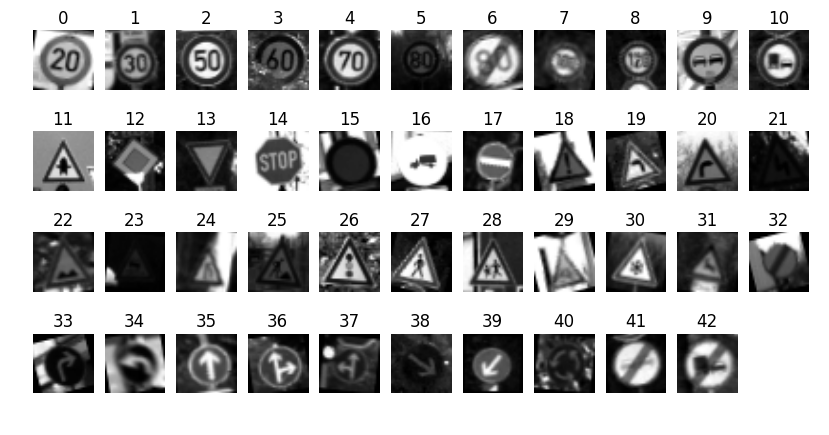

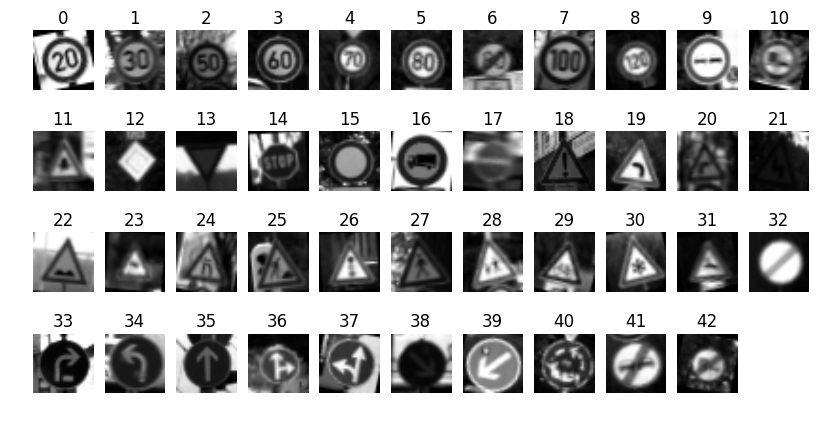

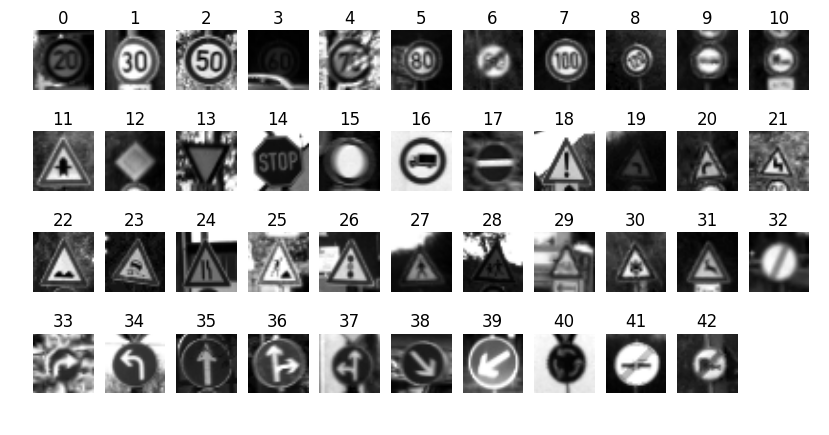

In [87]:
plotImages2(1, getSampleImage(X_train_final, y_train_final))
plotImages2(2, getSampleImage(X_valid, y_valid))
plotImages2(3, getSampleImage(X_test_cvt, y_test))

In [88]:
# Save the data for easy access

pickle_file = 'TrafficSigns.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train_final,
                    'train_labels': y_train_1hot,
                    'valid_dataset': X_valid,
                    'valid_labels': y_valid_1hot,
                    'test_dataset': X_test_cvt,
                    'test_labels': y_test_1hot,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

Additional jittered images have been generated with randomly transformation of existing images. The reason to add jittered images is to yield more robust learning results. Jittered images has been added to each class to make 3000 total images for each class in order to keep classes balanced.

The validation data are splited from extended training data set with random stratified split. About 60 data instances are splited as the validation data. The rest of extended training data will be used as the training data. The testing data keep the same.

In [89]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Reload the data
pickle_file = 'TrafficSigns.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['train_dataset']
  y_train = pickle_data['train_labels']
  X_valid = pickle_data['valid_dataset']
  y_valid = pickle_data['valid_labels']
  X_test = pickle_data['test_dataset']
  y_test = pickle_data['test_labels']
  del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


In [97]:
EPOCHS = 10
BATCH_SIZE = 64

def convNet(x):
    BETA = 0.001
    KEEP_PROB = 0.5
    
    # 32x32x16
    conv1_1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16)))
    conv1_1_b = tf.Variable(tf.zeros(16))
    conv1_1 = tf.nn.conv2d(x, conv1_1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_1_b
    conv1_1 = tf.nn.relu(conv1_1)
    
    # 32x32x16
    conv1_2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16)))
    conv1_2_b = tf.Variable(tf.zeros(16))
    conv1_2 = tf.nn.conv2d(conv1_1, conv1_2_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_2_b
    conv1_2 = tf.nn.relu(conv1_2)

    # 16x16x16 = 4096
    conv1_2 = tf.nn.max_pool(conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1_2 = tf.nn.dropout(conv1_2, KEEP_PROB)

    # 16x16x32
    conv2_1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32)))
    conv2_1_b = tf.Variable(tf.zeros(32))
    conv2_1 = tf.nn.conv2d(conv1_2, conv2_1_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_1_b
    conv2_1 = tf.nn.relu(conv2_1)
    
    # 16x16x64
    conv2_2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64)))
    conv2_2_b = tf.Variable(tf.zeros(64))
    conv2_2 = tf.nn.conv2d(conv2_1, conv2_2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_2_b
    conv2_2 = tf.nn.relu(conv2_2)

    # 8x8x64 = 4096
    conv2_2 = tf.nn.max_pool(conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2_2 = tf.nn.dropout(conv2_2, KEEP_PROB)
    
    # 8x8x128
    conv3_1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128)))
    conv3_1_b = tf.Variable(tf.zeros(128))
    conv3_1 = tf.nn.conv2d(conv2_2, conv3_1_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_1_b
    conv3_1 = tf.nn.relu(conv3_1)
    
    # 8x8x256
    conv3_2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 256)))
    conv3_2_b = tf.Variable(tf.zeros(256))
    conv3_2 = tf.nn.conv2d(conv3_1, conv3_2_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_2_b
    conv3_2 = tf.nn.relu(conv3_2)

    # 4x4x256 = 4096
    conv3_2 = tf.nn.max_pool(conv3_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3_2 = tf.nn.dropout(conv3_2, KEEP_PROB)
    
    # 4x4x512
    conv4_1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 256, 512)))
    conv4_1_b = tf.Variable(tf.zeros(512))
    conv4_1 = tf.nn.conv2d(conv3_2, conv4_1_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_1_b
    conv4_1 = tf.nn.relu(conv4_1)
    
    # 4x4x1024
    conv4_2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 512, 1024)))
    conv4_2_b = tf.Variable(tf.zeros(1024))
    conv4_2 = tf.nn.conv2d(conv4_1, conv4_2_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_2_b
    conv4_2 = tf.nn.relu(conv4_2)

    # 2x2x1024 = 4096
    conv4_2 = tf.nn.max_pool(conv4_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4_2 = tf.nn.dropout(conv4_2, KEEP_PROB)

    # Flatten
    fc1 = tf.concat(1, [flatten(conv1_2), flatten(conv2_2), flatten(conv3_2), flatten(conv4_2)])
    # (16384, 2048)
    fc1_shape = (fc1.get_shape().as_list()[-1], 2048)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
    fc1_b = tf.Variable(tf.zeros(2048))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, KEEP_PROB)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(2048, 256)))
    fc2_b = tf.Variable(tf.zeros(256))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, KEEP_PROB)
    
    fc3_W = tf.Variable(tf.truncated_normal(shape=(256, 43)))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    l2_norm = BETA * (tf.nn.l2_loss(conv1_1_W) + tf.nn.l2_loss(conv1_2_W) +
                     tf.nn.l2_loss(conv2_1_W) + tf.nn.l2_loss(conv2_2_W) +
                     tf.nn.l2_loss(conv3_1_W) + tf.nn.l2_loss(conv3_2_W) +
                     tf.nn.l2_loss(conv4_1_W) + tf.nn.l2_loss(conv4_2_W) +
                     tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W) +
                     tf.nn.l2_loss(fc3_W))
    
    return logits, l2_norm

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.float32, (None, 43))
logits, l2_norm = convNet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y) + l2_norm) 
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.005, global_step, 10000, 0.95)
opt = tf.train.AdamOptimizer(learning_rate)
train_op = opt.minimize(loss_op, global_step=global_step)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def eval_data(X_data, y_data):
    '''Given a dataset as input returns the loss and accuracy.'''
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy =  sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * batch_x.shape[0])
        total_loss     += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_accuracy / num_examples

In [ ]:
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
            
        valid_loss, valid_accuracy = eval_data(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss     = {:.3f}".format(valid_loss))
        print("Validation Accuracy = {:.3f}".format(valid_accuracy))
        print()
        
    # Evaluate on the test data
    test_loss, test_acc = eval_data(X_test, y_test)
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'ConvNet')
    print("Model saved")

Training...



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.